# Introduction and Using my Simulator

The problem I tackled in this project was training a deep Q-learner to play 3D tetris. 3D tetris is a generalization of
standard tetris, but stepped up one dimension. I implemented it with an interface that should make it ideal for deep
learning type projects.

To create an instance of the game we can run the following code:

In [3]:
import tetris3d as t3d

# tetris settings
clear_reward = 10
clear_exponent = 2
pieces_reward = 0.25
packing_reward = 0.07
reachability_reward = packing_reward / 2
game_over_penalty = -500

board_shape = [5, 5, 20]

tetris_instance = t3d.GameState(board_shape=board_shape, rewards=[clear_reward, clear_exponent, pieces_reward,
                                                              packing_reward, reachability_reward, game_over_penalty])

Using TensorFlow backend.


We can get the set of actions available using `tetris_instace.action_space` and update the game using those actions by
simply calling `tetris_instace(action)`

I also implemented a renderer using matplotlib. For example, the following code generates an animation of my most 
recently trained agent playing a game, but jupyter doesn't allow for inline animation:

Instructions for updating:
Colocations handled automatically by placer.


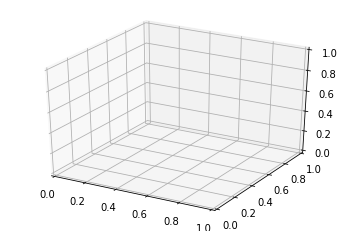

In [4]:
from keras.models import model_from_json
import pickle
import render
import matplotlib.pyplot as plt

save_name = 'oleg_last_try_2'

with open('models/' + save_name + '.json', 'r') as mod:
    model = model_from_json(mod.read())

weights = pickle.load(open("saved_model_weights/" + save_name + ".pkl", 'rb'))
model.set_weights(weights[len(weights) - 1])

fig = plt.figure()
ax = fig.gca(projection='3d')

# uncomment this for the animation
# render.render_from_model(model, fig, ax, tetris_instance)

# Rewards Scheme

The main difficulty of this project was coming up with a rewards scheme that would make the task actually learnable. At
first blush, it seems like simply using the conventional tetris scoring scheme should work: 

$r_t = kn^2$

for some constant $k$ and number of lines cleared $n$ on tick $t$.

I also added a game over penalty as is common for some video game deep learning problems to speed up learning. Finally,
to disincentivize useless moves, I added a small penalty for taking a move. The results were, in a word, 
less than stellar:

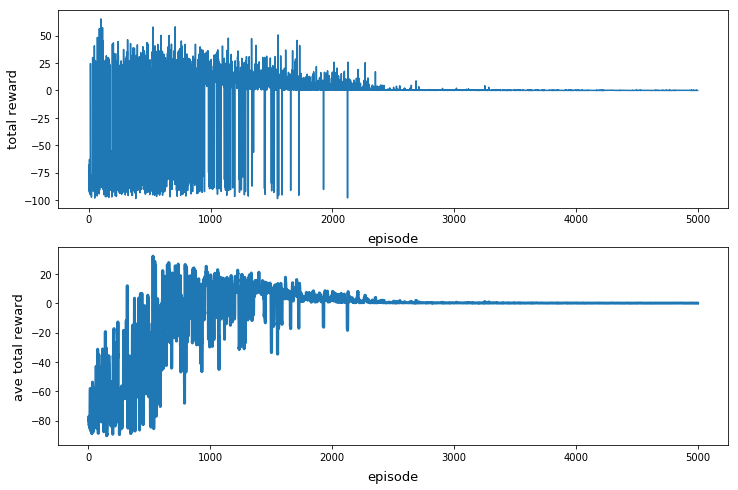

In [5]:
render.plot_reward_history('reward_logs/tetris4.txt')


The problem with this scheme is that clearing a line at random is extremely
rare. I have run 30,000 games at random and not scored a single line clear, which means that, during the exploration
phase, our learner isn't gaining any useful information. Moreover the only behavior it did learn was to never take any
moves:


In [ ]:
from IPython.display import HTML

HTML("""
<video width="320" height="240" controls>
  <source src="images/2lbl_F.mp4" type="video/mp4">
</video>
""")


However, removing that penalty on its own led to wild vibrations like this:


In [1]:
from IPython.display import HTML

HTML("""
<video width="320" height="240" controls>
  <source src="images/naive_tetris_1.mp4" type="video/mp4">
</video>
""")


The rewards scheme I settled on was:

$r_t = 0.8 \times c + 0.15 \times p + 0.075 \times r + 0.25 \times n - 500 \times g$ 

where $c$ is the total conventional tetris score, $p$ the packing efficiency, $r$ the percentage of the board that is 
reachable, $n$ the number of pieces and $g$ a binary variable that detects if we have gotten a game over.

(Packing efficiency is simply the ratio of pieces to spaces evaluated over non empty rows)

This metric hopefully disambiguates good board states from bad, though it doesn't emphasize board clears perhaps as much
as it should.

Training on this metric, our rewards history is unimpressive to say the least. However, this may just be because I ran
out of time to train:


In [2]:
render.plot_reward_history('reward_logs/oleg.txt')


NameError: name 'render' is not defined

# Performance, Architecture, and some Finer Details

The algorithm I used was fitted Q learning with a shared architecture as we discussed in lecture and in our notes.

I used a fully connected network with two hidden layers of 50 and 100 neurons at first. I later upped this to 500 and 
1000 neurons respectively since I hoped that it would capture more of the complexity of the game and therefore improve
accuracy. (I also figured out how to utilize my GPU for tensorflow about halfway through the project, which also prompted 
this jump up in complexity)

I included a batch normalization layer between the two fully connected layers since in our problem sets
standard normalization was hugely useful. Another improvement I made was optimizing with respect to Huber loss, which is
useful since it doesn't heavily emphasize rewards that are high magnitude like MSE does while still being everywhere
differentiable unlike MAE. This is useful in this project since the game over penalty is so high and occurs commonly, 
making the network slower to converge under MSE. The loss function is as follows

$h(t, Q) = \begin{cases}
\frac{1}{2}(a_t - Q(s_t))^2 & |a_t - Q(s_t)| \leq 1 \\
|a_t - Q(s_t)| - \frac{1}{2} & else
\end{cases}$

I chose to optimize in batches of 20 episodes every 10 episodes. The intent behind updating only every 10 episodes was
to allow the agent to explore more games before optimizing in the hopes of finding a game that contained a line clear.
Then, with the high weighting given to board clears, the Q function can update towards the desired result.

With this configuration, we achieve something that looks quite a bit better than the vibrating pieces in our naive
implementation, though it is still nowhere near close to being able to play the game well: 


In [ ]:
HTML("""
<video width="320" height="240" controls>
  <source src="images/2lbl.mp4" type="video/mp4">
</video>
""")


# Conclusions and Further Directions

I would be hesitant to call this project a failure in that I managed to make progress, I think, to solving the problem.
At the same time, it would be a stretch to call it a success.

The reward scheme that I developed captures what makes a good board state different from a bad board state. However, 
I think it is still too simplistic and a more complicated and robust scheme would encourage faster learning. On the 
other hand, its possible that I simply did not do enough training episodes, given the relative complexity of the game.

In the future, I might try the "more fire power" approach of optimizing a more complicated network over larger batches
for more episodes -- essentially throwing compute power at the problem and hoping that it resolves. I do think that this
is one of the short comings of my project: simply not training for enough episodes.

I might also try a convolutional approach since the data we're working with seems ripe for it. However, I chose not to
since I had hoped that a simple fully connected network would be sufficient given enough computing time and wanted to 
get the "basic" architecture working before trying the other approach.

Finally, I might adopt the approach used in [this paper](http://cs231n.stanford.edu/reports/2016/pdfs/121_Report.pdf)
which was to first begin with a model to pack the board efficiently and then use transfer learning to fit a model that
would actually clear lines. This gets around the problem of clearing lines and packing the board being similar, but not 
actually identical objectives.

All in all I learned a lot in the project and though it was frustrating at times, I'm eager to keep working on it and am
confident that with more work, I can eventually engineer a solution.